# Insurance Fraud Detection Capstone Project


## Introduction

Insurance fraud is a growing concern in the industry, resulting in billions of dollars in losses each year.
This project aims to build a robust machine learning model to identify fraudulent insurance claims,
helping insurers reduce risk and improve operational efficiency.

## Business Understanding

The goal is to develop a model that can accurately predict whether a given claim is fraudulent.
Accurate fraud detection helps insurers save money, allocate resources efficiently, and protect customers from
rising premiums due to fraudulent activity.

We will evaluate models based on precision, recall, and the F1-score—metrics better suited for imbalanced classification tasks.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [56]:
# Load dataset
df = pd.read_csv("insurance_claims.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN



## Exploratory Data Analysis (EDA)

We'll explore categorical and continuous variables and check class balance.


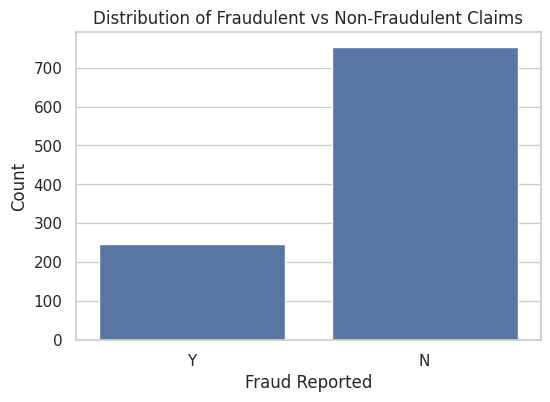

In [31]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='fraud_reported')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Claims")
plt.xlabel("Fraud Reported")
plt.ylabel("Count")
plt.show()


## Data Cleaning & Preprocessing

Handling missing values, encoding categorical variables, and applying scaling.


In [57]:
# Drop columns with high missingness or no variance
df.drop(['_c39', 'policy_bind_date', 'incident_date'], axis=1, inplace=True)

# Drop rows with missing values for simplicity (alternative: imputation)
df.dropna(inplace=True)

# Encode target variable
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [33]:
null_counts = df.isnull().sum()
print(null_counts)


months_as_customer       0
age                      0
policy_number            0
policy_deductable        0
policy_annual_premium    0
                        ..
auto_model_Tahoe         0
auto_model_Ultima        0
auto_model_Wrangler      0
auto_model_X5            0
auto_model_X6            0
Length: 1054, dtype: int64


## Model Training and Evaluation

In [34]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    results.append((name, acc, prec, rec, f1))

pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.769231,0.581081,0.796296,0.671875
1,Random Forest,0.703297,0.500000,0.074074,0.129032
2,Gradient Boosting,0.840659,0.727273,0.740741,0.733945
3,Support Vector Machine,0.296703,0.296703,1.000000,0.457627
4,K-Nearest Neighbors,0.296703,0.296703,1.000000,0.457627


## Grid Search for Model Optimization

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

logreg_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}
logreg = LogisticRegression()
logreg_grid = GridSearchCV(logreg, logreg_params, scoring='f1', cv=5)
logreg_grid.fit(X_train_scaled, y_train_res)
logreg_best = logreg_grid.best_estimator_
y_pred_logreg = logreg_best.predict(X_test_scaled)
print("Best Parameters:", logreg_grid.best_params_)
print(classification_report(y_test, y_pred_logreg))


Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       128
           1       0.59      0.67      0.63        54

    accuracy                           0.76       182
   macro avg       0.72      0.74      0.73       182
weighted avg       0.77      0.76      0.77       182



### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, rf_params, scoring='f1', cv=5)
rf_grid.fit(X_train_scaled, y_train_res)
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test_scaled)
print("Best Parameters:", rf_grid.best_params_)
print(classification_report(y_test, y_pred_rf))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       128
           1       0.50      0.04      0.07        54

    accuracy                           0.70       182
   macro avg       0.60      0.51      0.45       182
weighted avg       0.65      0.70      0.60       182



### 🚀 Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb, gb_params, scoring='f1', cv=5)
gb_grid.fit(X_train_scaled, y_train_res)
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test_scaled)
print("Best Parameters:", gb_grid.best_params_)
print(classification_report(y_test, y_pred_gb))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       128
           1       0.75      0.70      0.72        54

    accuracy                           0.84       182
   macro avg       0.81      0.80      0.81       182
weighted avg       0.84      0.84      0.84       182



### Support Vector Machine

In [38]:
from sklearn.svm import SVC

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm = SVC(probability=True)
svm_grid = GridSearchCV(svm, svm_params, scoring='f1', cv=5)
svm_grid.fit(X_train_scaled, y_train_res)
svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test_scaled)
print("Best Parameters:", svm_grid.best_params_)
print(classification_report(y_test, y_pred_svm))

Best Parameters: {'C': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.30      1.00      0.46        54

    accuracy                           0.30       182
   macro avg       0.15      0.50      0.23       182
weighted avg       0.09      0.30      0.14       182



### K-Nearest Neighbors

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, scoring='f1', cv=5)
knn_grid.fit(X_train_scaled, y_train_res)
knn_best = knn_grid.best_estimator_
y_pred_knn = knn_best.predict(X_test_scaled)
print("Best Parameters:", knn_grid.best_params_)
print(classification_report(y_test, y_pred_knn))

Best Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.30      1.00      0.46        54

    accuracy                           0.30       182
   macro avg       0.15      0.50      0.23       182
weighted avg       0.09      0.30      0.14       182



## Model Comparison Summary

In [40]:
summary_results = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "SVM", "KNN"],
    "F1 Score": [
        f1_score(y_test, y_pred_logreg),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_knn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_logreg),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_knn)
    ],
    "Recall": [
        recall_score(y_test, y_pred_logreg),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_knn)
    ]
}
pd.DataFrame(summary_results)

,Model,F1 Score,Precision,Recall
0,Logistic Regression,0.626087,0.590164,0.666667
1,Random Forest,0.068966,0.500000,0.037037
2,Gradient Boosting,0.723810,0.745098,0.703704
3,SVM,0.457627,0.296703,1.000000
4,KNN,0.457627,0.296703,1.000000


## Visual Evaluation of Models

### Logistic Regression: Confusion Matrix, ROC & Precision-Recall Curve

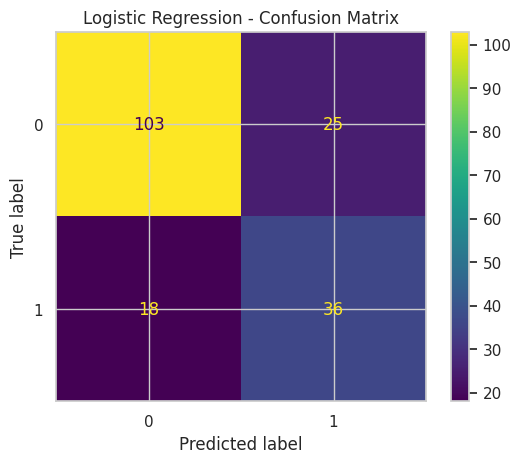

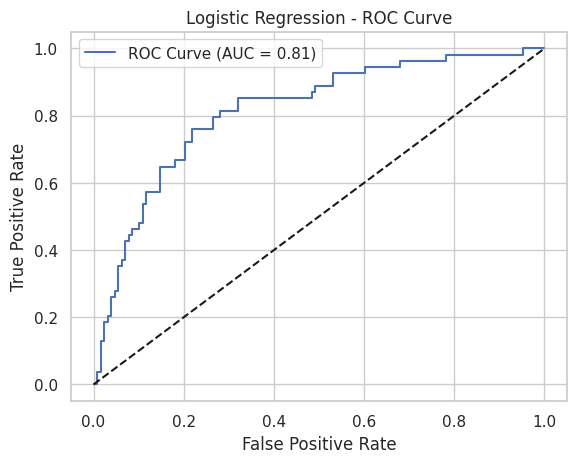

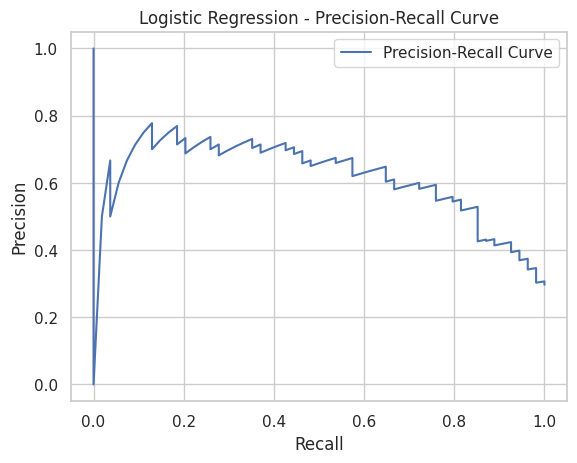

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(logreg_best, X_test_scaled, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, logreg_best.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, logreg_best.predict_proba(X_test_scaled)[:,1])
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.title("Logistic Regression - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### Random Forest: Confusion Matrix, ROC & Feature Importance

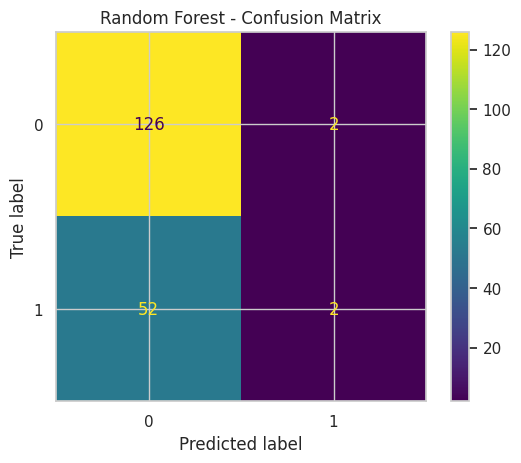

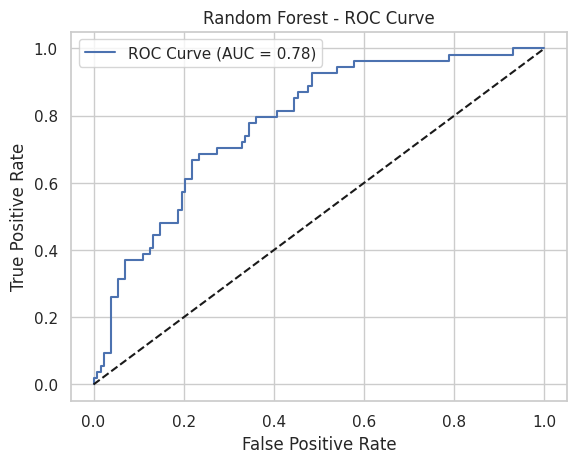

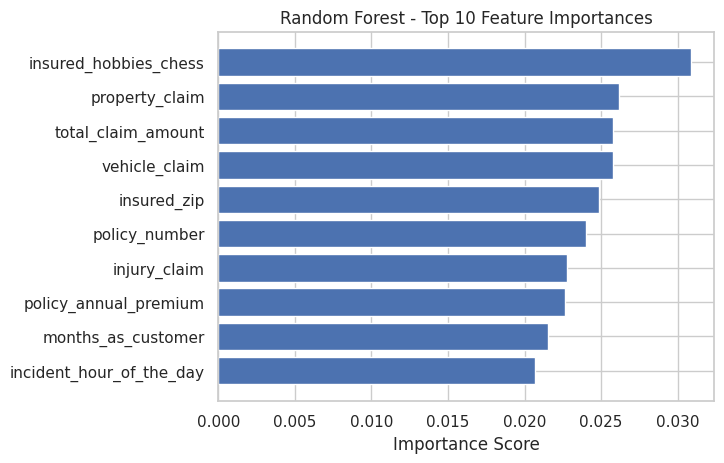

In [42]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_best, X_test_scaled, y_test)
plt.title("Random Forest - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_best.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("Random Forest - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Feature Importance
importances = rf_best.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Random Forest - Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

### Gradient Boosting: Confusion Matrix, ROC & Feature Importance

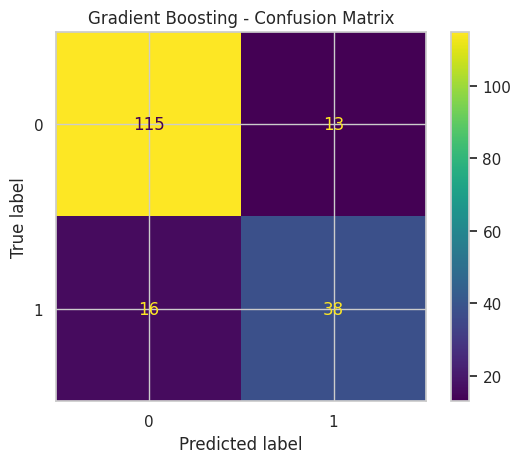

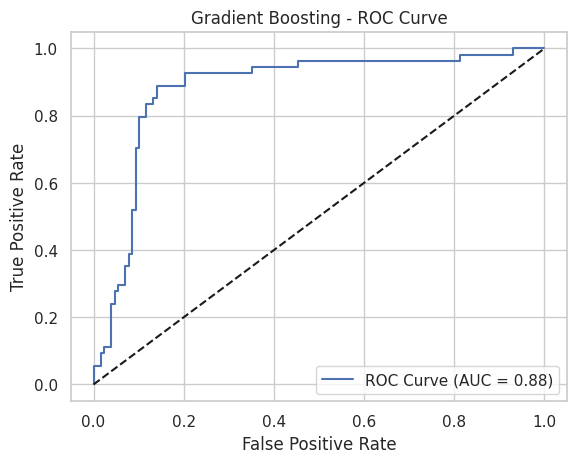

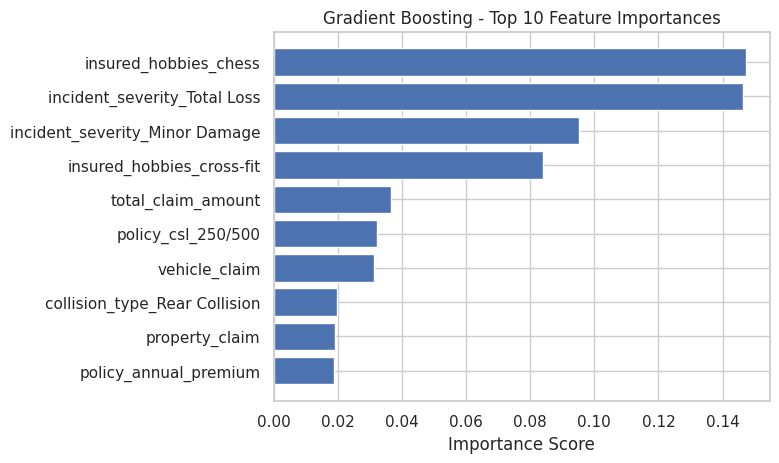

In [43]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(gb_best, X_test_scaled, y_test)
plt.title("Gradient Boosting - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gb_best.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("Gradient Boosting - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Feature Importance
importances = gb_best.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Gradient Boosting - Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

### Support Vector Machine: Confusion Matrix, ROC & Precision-Recall Curve

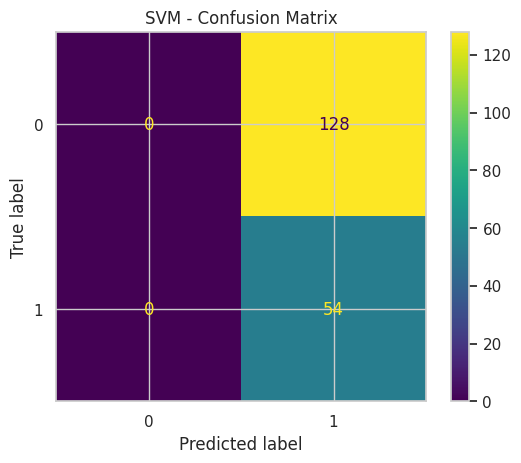

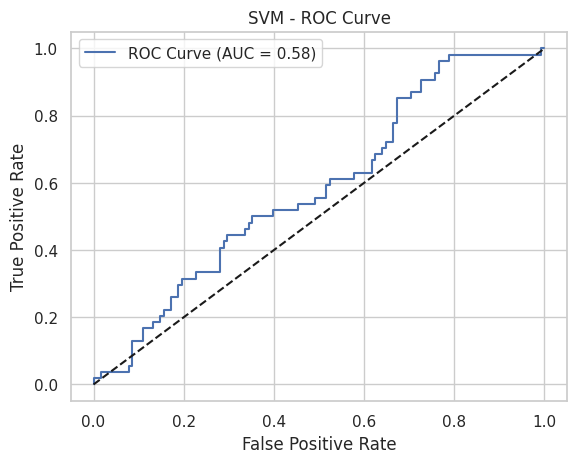

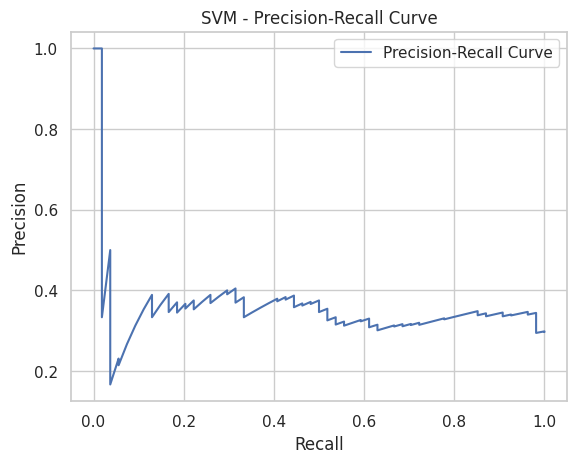

In [44]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_best, X_test_scaled, y_test)
plt.title("SVM - Confusion Matrix")
plt.show()

# ROC Curve (requires probability estimates)
fpr, tpr, _ = roc_curve(y_test, svm_best.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("SVM - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, svm_best.decision_function(X_test_scaled))
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.title("SVM - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### K-Nearest Neighbors: Confusion Matrix & ROC Curve

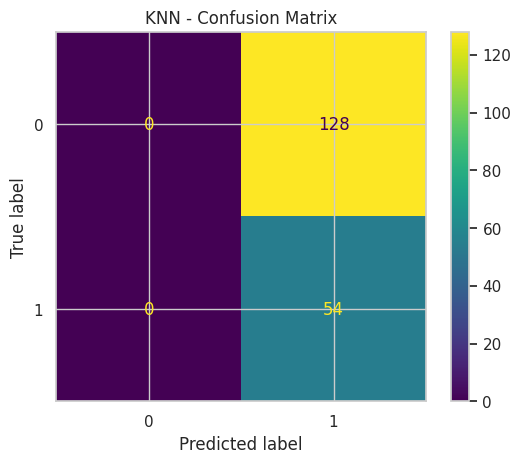

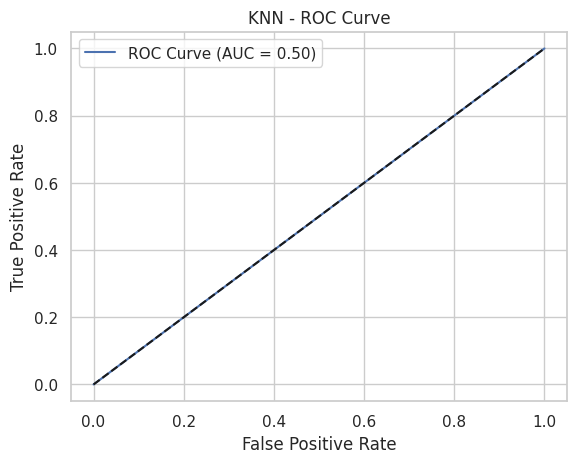

In [45]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_best, X_test_scaled, y_test)
plt.title("KNN - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, knn_best.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("KNN - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Visual Comparison of Features Related to Fraud

### Categorical Feature Relationships

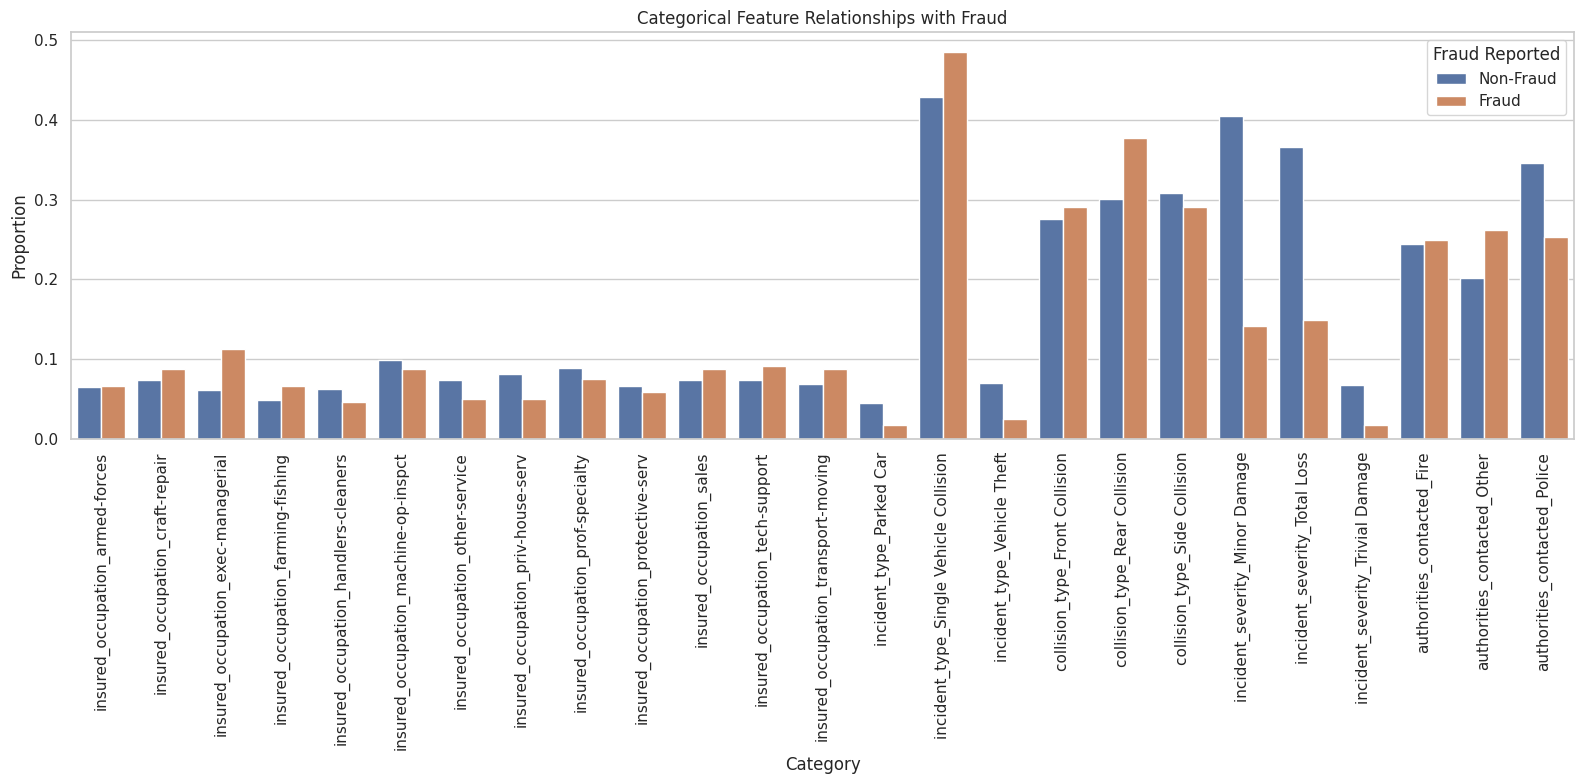

In [60]:
# 📊 Visualizing One-Hot Encoded Categorical Feature Relationships

# Define dummy variable groups based on known prefixes
cat_dummy_prefixes = [
    'incident_type_',
    'collision_type_',
    'incident_severity_',
    'authorities_contacted_',
    'insured_occupation_'
]

# Collect relevant one-hot columns
cat_dummy_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in cat_dummy_prefixes)]

# Calculate mean (i.e., proportion of 1s) grouped by fraud_reported
dummy_means = df.groupby('fraud_reported')[cat_dummy_cols].mean().T
dummy_means.columns = ['Non-Fraud', 'Fraud']
dummy_means = dummy_means.reset_index().rename(columns={'index': 'Category'})

# Melt for seaborn barplot
plot_df = dummy_means.melt(id_vars='Category', var_name='Fraud Reported', value_name='Proportion')

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=plot_df, x='Category', y='Proportion', hue='Fraud Reported')
plt.title("Categorical Feature Relationships with Fraud")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Numerical Feature Relationships

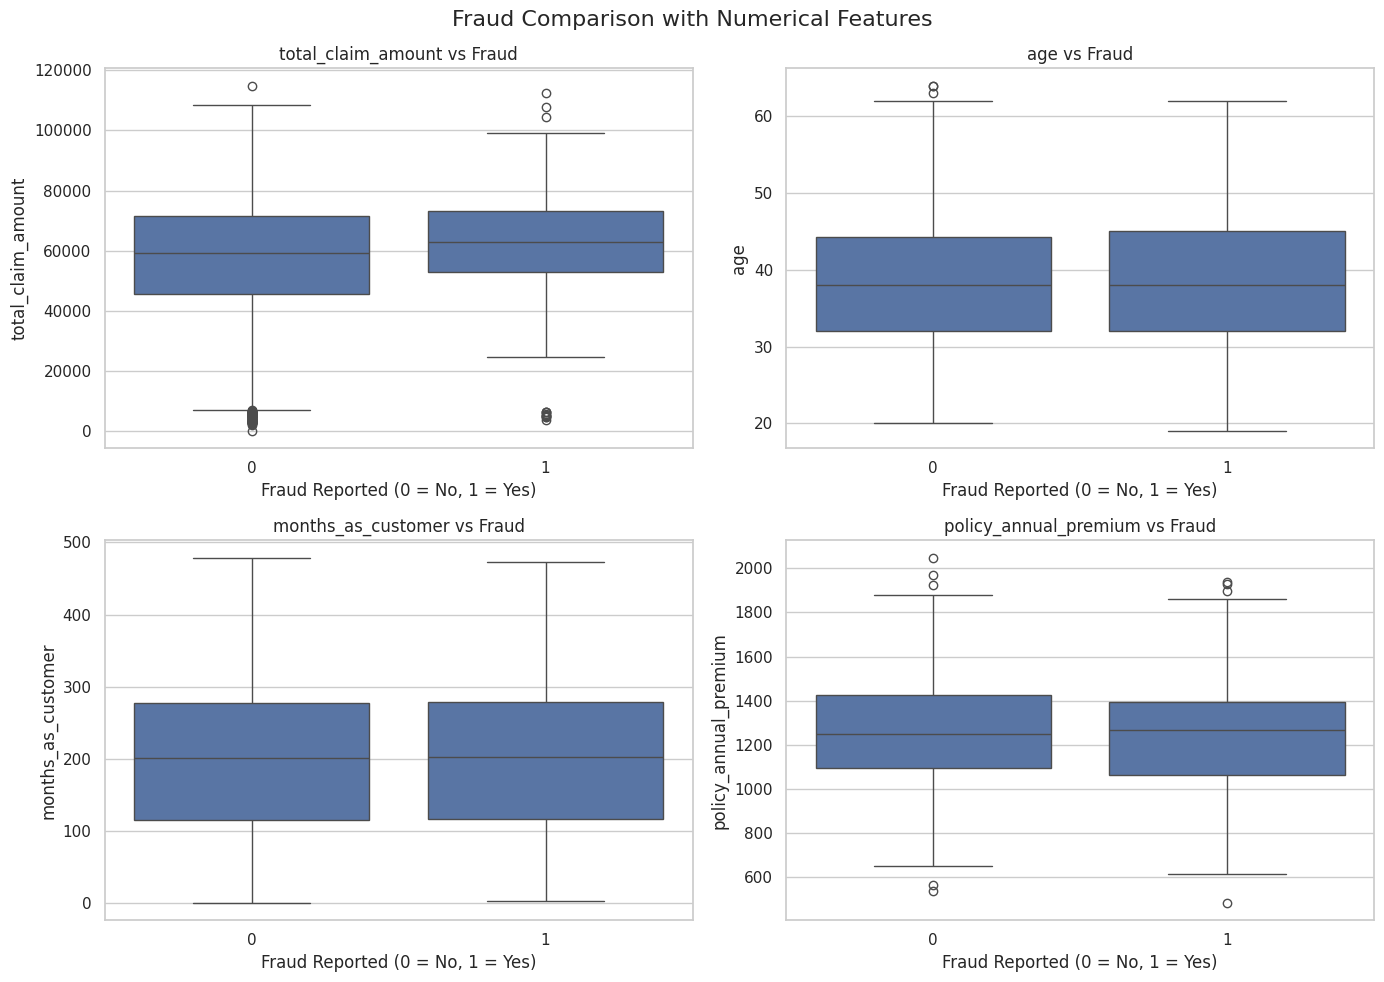

In [61]:
fig_num, axes_num = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes_num = axes_num.flatten()

numerical_cols = ['total_claim_amount', 'age', 'months_as_customer', 'policy_annual_premium']

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='fraud_reported', y=col, ax=axes_num[i])
    axes_num[i].set_title(f"{col} vs Fraud")
    axes_num[i].set_xlabel("Fraud Reported (0 = No, 1 = Yes)")

fig_num.suptitle("Fraud Comparison with Numerical Features", fontsize=16)
fig_num.tight_layout()
plt.show()


### Insights from Visual Comparison

Based on the visual exploration of key features in relation to fraud:

#### Categorical Features
- **Incident Type**: Certain types, such as single-vehicle collisions, appear to have higher fraud rates.
- **Collision Type**: Rear-end collisions have the highest fraud rate, while sideswiped or front colisions still have relatively high fraud rates (Almost equal to non-fraud cases)
- **Incident Severity**: Incident Serverity of "Minor" and "Total Loss" have a ratio of fradulant cases to non-frudulant in about a 1:2 ratio.
- **Insured Occupation**: Some professions (e.g. Sales, Tech Support and Transport Moving) have a much higher fraud reporting than other profressions.
- **Authorities Contacted**: Fraud cases are more likely to involve situations where the police were the authorities contacted have the lowest amount of fradulant claims. This suggests that those who commit fraud will be less likely to contact the police during an incident.

#### Numerical Features
- **Total Claim Amount**:
Fraudulent claims have notably higher claim amounts.

* Median: $61,290 (fraud) vs. $56,520 (non-fraud)

* Max values are very similar, but fraud claims are skewed higher overall.

- **Age**:
* Little to no difference between fraud and non-fraud groups.

* Both have a median age around 38–39 years.

- **Months as Customer**:
* Slightly higher average for fraudulent claims.

* Mean: ~208 months (fraud) vs. ~202 months (non-fraud)

* Suggests fraud isn’t just a new-customer issue.

- **Policy Annual Premium**:
* No significant difference between fraud and non-fraud claims.

* Both groups center around $1,250/year.

These insights can help inform which variables are most useful in detecting fraudulent behavior and improving the model’s ability to catch it.
